# Install LLM, RAG dependencies

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


In [56]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-openai langchain-qdrant

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import sys
import time
import json
from typing import List, Dict, Text, Optional, AsyncIterator, Iterator

import dotenv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

print("Python version: {}". format(sys.version))
print("NumPy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))

from langchain_core.document_loaders import BaseLoader
from langchain_core.documents import Document
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import CSVLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_qdrant import QdrantVectorStore

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
NumPy version: 1.26.4
pandas version: 2.2.3
matplotlib version: 3.7.5


# 1.0 Load data

In [4]:
DATA_FOLDER = "/kaggle/input/dungeons-dragons/"
# DATA_FOLDER = "../data/dungeons-dragons/"

CLASSES_FILE = "classes.csv"
RACES_FILE = "races.csv"
MONSTERS_FILE = "monsters.csv"
EQUIPMENT_FILE = "equipment.csv"
SPELLS_FILE = "spells.csv"

In [5]:
races_df = pd.read_csv(os.path.join(DATA_FOLDER, RACES_FILE))
classes_df = pd.read_csv(os.path.join(DATA_FOLDER, CLASSES_FILE))
monsters_df = pd.read_csv(os.path.join(DATA_FOLDER, MONSTERS_FILE))
equipment_df = pd.read_csv(os.path.join(DATA_FOLDER, EQUIPMENT_FILE))
spells_df = pd.read_csv(os.path.join(DATA_FOLDER, SPELLS_FILE))

In [6]:
races_df = pd.read_csv(os.path.join(DATA_FOLDER, RACES_FILE))

# print(len(races_df))
races_df.head(10)

,Unnamed: 0,_id,index,name,speed,ability_bonuses,alignment,age,size,size_description,starting_proficiencies,languages,language_desc,traits,trait_options,subraces,url,starting_proficiency_options,ability_bonus_options,language_options
0,0,5f2329af0b1bb138c59413c3,dragonborn,Dragonborn,30,"[{'name': 'STR', 'url': '/api/ability-scores/s...","Dragonborn tend to extremes, making a conscio...",Young dragonborn grow quickly. They walk hours...,Medium,"Dragonborn are taller and heavier than humans,...",[],"[{'url': '/api/languages/common', 'name': 'Com...","You can speak, read, and write Common and Drac...","[{'name': 'Draconic Ancestry', 'url': '/api/tr...","{'choose': 1, 'from': [{'name': 'Breath Weapon...",[],/api/races/dragonborn,NaN,NaN,NaN
1,1,5f2329af0b1bb138c59413c0,dwarf,Dwarf,30,"[{'name': 'CON', 'url': '/api/ability-scores/c...","Most dwarves are lawful, believing firmly in t...","Dwarves mature at the same rate as humans, but...",Medium,Dwarves stand between 4 and 5 feet tall and av...,"[{'url': '/api/proficiencies/battleaxes', 'nam...","[{'url': '/api/languages/common', 'name': 'Com...","You can speak, read, and write Common and Dwar...","[{'name': 'Darkvision', 'url': '/api/traits/da...",NaN,"[{'url': '/api/subraces/hill-dwarf', 'name': '...",/api/races/dwarf,"{'choose': 1, 'type': 'proficiencies', 'from':...",NaN,NaN
2,2,5f2329af0b1bb138c59413bf,elf,Elf,30,"[{'name': 'DEX', 'url': '/api/ability-scores/d...","Elves love freedom, variety, and self-expressi...",Although elves reach physical maturity at abou...,Medium,Elves range from under 5 to over 6 feet tall a...,[{'url': '/api/proficiencies/skill-perception'...,"[{'url': '/api/languages/common', 'name': 'Com...","You can speak, read, and write Common and Elvi...","[{'name': 'Darkvision', 'url': '/api/traits/da...",NaN,"[{'url': '/api/subraces/high-elf', 'name': 'Hi...",/api/races/elf,NaN,NaN,NaN
3,3,5f2329af0b1bb138c59413c4,gnome,Gnome,25,"[{'name': 'INT', 'url': '/api/ability-scores/i...",Gnomes are most often good. Those who tend tow...,"Gnomes mature at the same rate humans do, and...",Small,Gnomes are between 3 and 4 feet tall and avera...,[],"[{'url': '/api/languages/common', 'name': 'Com...","You can speak, read, and write Common and Gnom...","[{'name': 'Darkvision', 'url': '/api/traits/da...",NaN,"[{'url': '/api/subraces/rock-gnome', 'name': '...",/api/races/gnome,NaN,NaN,NaN
4,4,5f2329af0b1bb138c59413c5,half-elf,Half-Elf,30,"[{'name': 'CHA', 'url': '/api/ability-scores/c...",Half-elves share the chaotic bent of their elv...,Half-elves mature at the same rate humans do a...,Medium,"Half-elves are about the same size as humans, ...",[],"[{'name': 'Common', 'url': '/api/languages/com...","You can speak, read, and write Common, Elvish,...","[{'name': 'Darkvision', 'url': '/api/traits/da...",NaN,[],/api/races/half-elf,NaN,"{'choose': 2, 'type': 'ability_bonuses', 'from...","{'choose': 1, 'type': 'languages', 'from': [{'..."
5,5,5f2329af0b1bb138c59413c6,half-orc,Half-Orc,30,"[{'name': 'STR', 'url': '/api/ability-scores/s...",Half-orcs inherit a tendency toward chaos fro...,"Half-orcs mature a little faster than humans, ...",Medium,Half-orcs are somewhat larger and bulkier than...,"[{'name': 'Skill: Intimidation', 'url': '/api/...","[{'url': '/api/languages/common', 'name': 'Com...","You can speak, read, and write Common and Orc....","[{'name': 'Darkvision', 'url': '/api/traits/da...",NaN,[],/api/races/half-orc,NaN,NaN,NaN
6,6,5f2329af0b1bb138c59413c1,halfling,Halfling,25,"[{'name': 'DEX', 'url': '/api/ability-scores/d...","Most halflings are lawful good. As a rule, the...",A halfling reaches adulthood at the age of 20 ...,Small,Halflings average about 3 feet tall and weigh ...,[],"[{'url': '/api/languages/common', 'name': 'Com...","You can speak, read, and write Common and Half...","[{'name': 'Brave', 'url': '/api/traits/brave'}...",NaN,"[{'url': '/api/subraces/lightfoot-halfling', '...",/api/races/halfling,NaN,NaN,NaN
7,7,5f2329af0b1bb138c59413c2,human,Human,30,"[{'

# 1.1 Describe data

In [7]:
# Getting Info
display(races_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    9 non-null      int64 
 1   _id                           9 non-null      object
 2   index                         9 non-null      object
 3   name                          9 non-null      object
 4   speed                         9 non-null      int64 
 5   ability_bonuses               9 non-null      object
 6   alignment                     9 non-null      object
 7   age                           9 non-null      object
 8   size                          9 non-null      object
 9   size_description              9 non-null      object
 10  starting_proficiencies        9 non-null      object
 11  languages                     9 non-null      object
 12  language_desc                 9 non-null      object
 13  traits                  

None

In [8]:
races_df.describe()

,Unnamed: 0,speed
count,9.000000,9.000000
mean,4.000000,28.888889
std,2.738613,2.204793
min,0.000000,25.000000
25%,2.000000,30.000000
50%,4.000000,30.000000
75%,6.000000,30.000000
max,8.000000,30.000000


In [9]:
print("Races:\n-", "\n- ".join(races_df['name'].tolist()[:10]))
print()
print("Classes:\n-", "\n- ".join(classes_df['name'].tolist()[:10]))
print()
print("Monsters:\n-", "\n- ".join(monsters_df.sample(10)['name'].tolist()))

Races:
- Dragonborn
- Dwarf
- Elf
- Gnome
- Half-Elf
- Half-Orc
- Halfling
- Human
- Tiefling

Classes:
- Barbarian
- Bard
- Cleric
- Druid
- Fighter
- Monk
- Paladin
- Ranger
- Rogue
- Sorcerer

Monsters:
- Animated Armor
- Mummy Lord
- Succubus/Incubus
- Werebear
- Homunculus
- Guardian Naga
- Clay Golem
- Awakened Tree
- Will-o'-Wisp
- Sea Horse


## Null values

In [10]:
# Checking NULL values
display(races_df.isnull().sum())

Unnamed: 0                      0
_id                             0
index                           0
name                            0
speed                           0
ability_bonuses                 0
alignment                       0
age                             0
size                            0
size_description                0
starting_proficiencies          0
languages                       0
language_desc                   0
traits                          0
trait_options                   8
subraces                        0
url                             0
starting_proficiency_options    8
ability_bonus_options           8
language_options                7
dtype: int64

# 1.2 EDA
## 1.2.1 Distribution of Speed

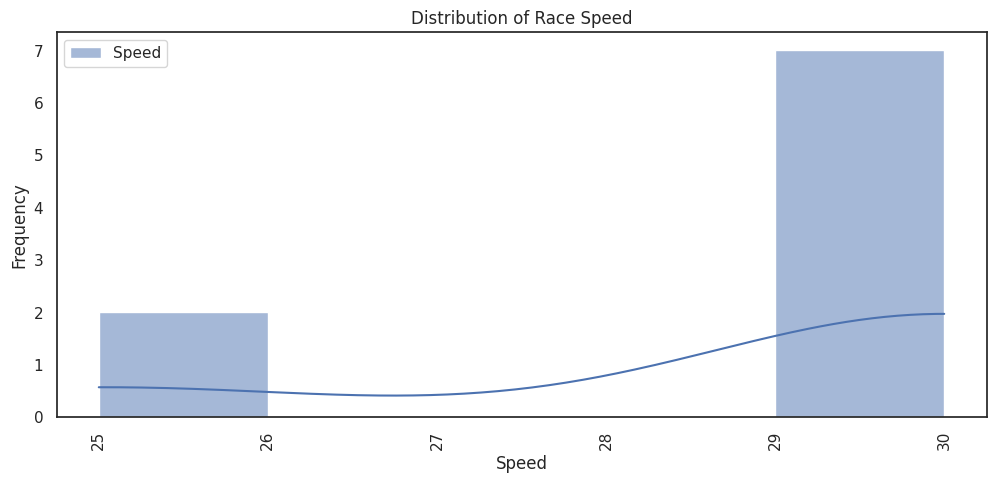

In [11]:
plt.figure(figsize=(12, 5))
sns.histplot(races_df['speed'], kde=True, label='Speed')
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.title("Distribution of Race Speed")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [12]:
races_df.head(1)

,Unnamed: 0,_id,index,name,speed,ability_bonuses,alignment,age,size,size_description,starting_proficiencies,languages,language_desc,traits,trait_options,subraces,url,starting_proficiency_options,ability_bonus_options,language_options
0,0,5f2329af0b1bb138c59413c3,dragonborn,Dragonborn,30,"[{'name': 'STR', 'url': '/api/ability-scores/s...","Dragonborn tend to extremes, making a conscio...",Young dragonborn grow quickly. They walk hours...,Medium,"Dragonborn are taller and heavier than humans,...",[],"[{'url': '/api/languages/common', 'name': 'Com...","You can speak, read, and write Common and Drac...","[{'name': 'Draconic Ancestry', 'url': '/api/tr...","{'choose': 1, 'from': [{'name': 'Breath Weapon...",[],/api/races/dragonborn,NaN,NaN,NaN


In [13]:
print(classes_df.columns.tolist())
TEXT_COLUMNS = ['index', 'name', 'alignment', 'age', 'size', 'size_description', 'language_desc']
JSON_COLUMNS = ['ability_bonuses', 'languages', 'traits']

['Unnamed: 0', '_id', 'index', 'name', 'hit_die', 'proficiency_choices', 'proficiencies', 'saving_throws', 'starting_equipment', 'class_levels', 'subclasses', 'url', 'spellcasting']


In [14]:
json.loads("[{\"name\": \"Draconic Ancestry\", \"url\": \"/api/traits/draconic-ancestry\"}, {\"name\": \"Breath Weapon\", \"url\": \"/api/traits/breath-weapon\"}, {\"name\": \"Damage Resistance\", \"url\": \"/api/traits/damage-resistance\"}]")

[{'name': 'Draconic Ancestry', 'url': '/api/traits/draconic-ancestry'},
 {'name': 'Breath Weapon', 'url': '/api/traits/breath-weapon'},
 {'name': 'Damage Resistance', 'url': '/api/traits/damage-resistance'}]

# 2.0 Retrieval Augmented Generation
## 2.0.0 Custom Data Loaders
### Document Loader for DND Races 

In [15]:
DOC_RACES_TEMPLATE = """
Race: {race}

Speed: {speed}
Alignment: \n{alignment}
Age: \n{age}
Size: {size}
Description of Size of {race}: \n{size_description}
Languages spoken by {race}: \n{language_desc}
Ability bonuses of {race}: {ability_bonuses}
Traits of {race}: {traits}
"""


def parse_traits(traits):
    final_text = ''
    traits = traits.replace("'",'\"')
    traits = json.loads(traits)
    for trait in traits:
        final_text += '\n- {}'.format(trait['name'])
    return final_text


def parse_ability_bonuses(ability_bonuses):
    final_text = ''
    ability_bonuses = ability_bonuses.replace("'",'\"')
    ability_bonuses = json.loads(ability_bonuses)
    for ab in ability_bonuses:
        final_text += '\n- {}'.format(ab['name'])
    return final_text


class DNDRaceDocumentLoader(BaseLoader):
    """An example document loader that reads a file line by line."""

    def __init__(self, file_path: str) -> None:
        """Initialize the loader with a file path.

        Args:
            file_path: The path to the file to load.
        """
        self.file_path = file_path

    # <-- Does not take any arguments
    def lazy_load(self) -> Iterator[Document]:
        """A lazy loader that reads a file line by line.

        When you're implementing lazy load methods, you should use a generator
        to yield documents one by one.
        """
        df = pd.read_csv(self.file_path)
        for row in df.itertuples():
            traits = parse_traits(row.traits)
            ability_bonuses = parse_ability_bonuses(row.ability_bonuses)
            language_desc = row.language_desc.replace(
                "You can", "{} can".format(row.name))
            page_content = DOC_RACES_TEMPLATE.format(
                race=row.name, speed=row.speed, alignment=row.alignment.strip(),
                age=row.age, size=row.size, size_description=row.size_description,
                language_desc=language_desc, ability_bonuses=ability_bonuses, traits=traits,
            )
            yield Document(
                page_content=page_content,
                metadata={
                    "row_number": row.Index, "id": row[2], "index": row[3], "category": "race", "source": self.file_path
                },
            )

In [16]:
loader_races = DNDRaceDocumentLoader(os.path.join(DATA_FOLDER, RACES_FILE))

In [17]:
## Test out the lazy load interface
for doc in loader_races.lazy_load():
    print()
    print(type(doc))
    print(doc)
    break


<class 'langchain_core.documents.base.Document'>
page_content='
Race: Dragonborn

Speed: 30
Alignment: 
Dragonborn tend to extremes, making a conscious choice for one side or the other in the cosmic war between good and evil. Most dragonborn are good, but those who side with evil can be terrible villains.
Age: 
Young dragonborn grow quickly. They walk hours after hatching, attain the size and development of a 10-year-old human child by the age of 3, and reach adulthood by 15. They live to be around 80.
Size: Medium
Description of Size of Dragonborn: 
Dragonborn are taller and heavier than humans, standing well over 6 feet tall and averaging almost 250 pounds. Your size is Medium.
Languages spoken by Dragonborn: 
Dragonborn can speak, read, and write Common and Draconic. Draconic is thought to be one of the oldest languages and is often used in the study of magic. The language sounds harsh to most other creatures and includes numerous hard consonants and sibilants.
Ability bonuses of D

In [18]:
print(len(classes_df))
classes_df.head(2)

12


,Unnamed: 0,_id,index,name,hit_die,proficiency_choices,proficiencies,saving_throws,starting_equipment,class_levels,subclasses,url,spellcasting
0,0,5f2329a70b1bb138c5940d30,barbarian,Barbarian,12,"[{'choose': 2, 'type': 'proficiencies', 'from'...","[{'name': 'Light armor', 'url': '/api/proficie...","[{'name': 'STR', 'url': '/api/ability-scores/s...","{'url': '/api/starting-equipment/1', 'class': ...","{'url': '/api/classes/barbarian/levels', 'clas...","[{'url': '/api/subclasses/berserker', 'name': ...",/api/classes/barbarian,NaN
1,1,5f2329a70b1bb138c5940d31,bard,Bard,8,"[{'choose': 3, 'type': 'proficiencies', 'from'...","[{'name': 'Light armor', 'url': '/api/proficie...","[{'name': 'DEX', 'url': '/api/ability-scores/d...","{'url': '/api/starting-equipment/2', 'class': ...","{'url': '/api/classes/bard/levels', 'class': '...","[{'url': '/api/subclasses/lore', 'name': 'Lore'}]",/api/classes/bard,"{'url': '/api/spellcasting/bard', 'class': 'Ba..."


In [19]:
classes_df.iloc[1].to_list()

[1,
 '5f2329a70b1bb138c5940d31',
 'bard',
 'Bard',
 8,
 "[{'choose': 3, 'type': 'proficiencies', 'from': [{'url': '/api/proficiencies/skill-acrobatics', 'name': 'Skill: Acrobatics'}, {'url': '/api/proficiencies/skill-animal-handling', 'name': 'Skill: Animal Handling'}, {'url': '/api/proficiencies/skill-arcana', 'name': 'Skill: Arcana'}, {'url': '/api/proficiencies/skill-athletics', 'name': 'Skill: Athletics'}, {'url': '/api/proficiencies/skill-deception', 'name': 'Skill: Deception'}, {'url': '/api/proficiencies/skill-history', 'name': 'Skill: History'}, {'url': '/api/proficiencies/skill-insight', 'name': 'Skill: Insight'}, {'url': '/api/proficiencies/skill-intimidation', 'name': 'Skill: Intimidation'}, {'url': '/api/proficiencies/skill-investigation', 'name': 'Skill: Investigation'}, {'url': '/api/proficiencies/skill-medicine', 'name': 'Skill: Medicine'}, {'url': '/api/proficiencies/skill-nature', 'name': 'Skill: Nature'}, {'url': '/api/proficiencies/skill-perception', 'name': 'Skill: 

### Document Loader for DND Classes

In [20]:
DOC_CLASSES_TEMPLATE = """
Class: {class_name}

Hit Die: {hit_die}
Proficiencies: {proficiencies}
Proficiency Choices: {proficiency_choices}
Saving Throws: {saving_throws}
Subclasses of {class_name}: {subclasses}
"""
# Starting Equipment: {starting_equipment}
# Class Levels: \n{class_levels}
# Spell-casting: {spellcasting}


def parse_proficiencies(proficiencies):
    final_text = ''
    try:
        # proficiencies = proficiencies.replace("'", '\"')
        # proficiencies = json.loads(proficiencies)
        proficiencies = eval(proficiencies)
        for proficiency in proficiencies:
            final_text += '\n- {}'.format(proficiency['name'])
        return final_text
    except Exception as e:
        # print(e)
        return final_text


def parse_proficiency_choices(proficiency_choices):
    final_text = 'Choose any {} from the following choices:'
    try:
        # proficiency_choices = proficiency_choices.replace("'", '\"')
        # proficiency_choices = json.loads(proficiency_choices)
        proficiency_choices = eval(proficiency_choices)
        for proficiency in proficiency_choices:
            final_text = final_text.format(proficiency['choose'])
            for p in proficiency['from']:
                final_text += '\n- {}'.format(p['name'])
        return final_text
    except Exception as e:
        # print(e)
        return final_text


def parse_saving_throws(saving_throws):
    final_text = ''
    try:
        # saving_throws = saving_throws.replace("'", '\"')
        # saving_throws = json.loads(saving_throws)
        saving_throws = eval(saving_throws)
        for el in saving_throws:
            final_text += '\n- {}'.format(el['name'])
        return final_text
    except Exception as e:
        # print(e)
        return final_text


# def parse_starting_equipment(starting_equipment):
#     final_text = ''
#     starting_equipment = starting_equipment.replace("'", '\"')
#     starting_equipment = json.loads(starting_equipment)
#     for el in starting_equipment:
#         final_text += '\n- {}'.format(el['name'])
#     return final_text


# def parse_class_levels(class_levels):
#     final_text = ''
#     class_levels = class_levels.replace("'", '\"')
#     class_levels = json.loads(class_levels)
#     for el in class_levels:
#         final_text += '\n- {}'.format(el['name'])
#     return final_text


def parse_subclasses(subclasses):
    final_text = ''
    try:
        # subclasses = subclasses.replace("'", '\"')
        # subclasses = json.loads(subclasses)
        subclasses = eval(subclasses)
        for el in subclasses:
            final_text += '\n- {}'.format(el['name'])
        return final_text
    except Exception as e:
        # print(e)
        return final_text


# def parse_spellcasting(spellcasting):
#     final_text = ''
#     spellcasting = spellcasting.replace("'", '\"')
#     spellcasting = json.loads(spellcasting)
#     for el in spellcasting:
#         final_text += '\n- {}'.format(el['name'])
#     return final_text


class DNDClassDocumentLoader(BaseLoader):
    """An example document loader that reads a file line by line."""

    def __init__(self, file_path: str) -> None:
        """Initialize the loader with a file path.

        Args:
            file_path: The path to the file to load.
        """
        self.file_path = file_path

    # <-- Does not take any arguments
    def lazy_load(self) -> Iterator[Document]:
        """A lazy loader that reads a file line by line.

        When you're implementing lazy load methods, you should use a generator
        to yield documents one by one.
        """
        df = pd.read_csv(self.file_path)
        for row in df.itertuples():
            proficiencies = parse_proficiencies(row.proficiencies)
            proficiency_choices = parse_proficiency_choices(row.proficiency_choices)
            saving_throws = parse_saving_throws(row.saving_throws)
            subclasses = parse_subclasses(row.subclasses)
            page_content = DOC_CLASSES_TEMPLATE.format(
                class_name=row.name, hit_die=row.hit_die, proficiencies=proficiencies,
                saving_throws=saving_throws, proficiency_choices=proficiency_choices, 
                subclasses=subclasses
            )
            yield Document(
                page_content=page_content,
                metadata={
                    "row_number": row.Index, "id": row[2], "index": row[3], "category": "class", "source": self.file_path
                },
            )

In [21]:
loader_classes = DNDClassDocumentLoader(os.path.join(DATA_FOLDER, CLASSES_FILE))
## Test out the lazy load interface
for doc in loader_classes.lazy_load():
    print()
    print(type(doc))
    print(doc)
    break


<class 'langchain_core.documents.base.Document'>
page_content='
Class: Barbarian

Hit Die: 12
Proficiencies: 
- Light armor
- Medium armor
- Shields
- Simple weapons
- Martial weapons
Proficiency Choices: Choose any 2 from the following choices:
- Skill: Animal Handling
- Skill: Athletics
- Skill: Intimidation
- Skill: Nature
- Skill: Perception
- Skill: Survival
Saving Throws: 
- STR
- CON
Subclasses of Barbarian: 
- Berserker
' metadata={'row_number': 0, 'id': '5f2329a70b1bb138c5940d30', 'index': 'barbarian', 'category': 'class', 'source': '/kaggle/input/dungeons-dragons/classes.csv'}


In [22]:
print(len(monsters_df))
pd.set_option('display.max_columns', 500)
monsters_df.head(2)

322


,Unnamed: 0,_id,index,name,size,type,subtype,alignment,armor_class,hit_points,hit_dice,speed,strength,dexterity,constitution,intelligence,wisdom,charisma,proficiencies,damage_vulnerabilities,damage_resistances,damage_immunities,condition_immunities,senses,languages,challenge_rating,special_abilities,actions,legendary_actions,url,reactions,other_speeds
0,0,5f2329ad0b1bb138c59411ee,aboleth,Aboleth,Large,aberration,NaN,lawful evil,17,135,18d10,"{'walk': '10 ft.', 'swim': '40 ft.'}",21,9,15,18,15,18,"[{'name': 'Saving Throw: CON', 'url': '/api/pr...",[],[],[],[],"{'darkvision': '120 ft.', 'passive_perception'...","Deep Speech, telepathy 120 ft.",10.00,"[{'name': 'Amphibious', 'desc': 'The aboleth c...","[{'name': 'Multiattack', 'desc': 'The aboleth ...","[{'name': 'Detect', 'desc': 'The aboleth makes...",/api/monsters/aboleth,NaN,NaN
1,1,5f2329ad0b1bb138c59411ef,acolyte,Acolyte,Medium,humanoid,any race,any alignment,10,9,2d8,{'walk': '30 ft.'},10,10,10,10,14,11,"[{'name': 'Skill: Medicine', 'url': '/api/prof...",[],[],[],[],{'passive_perception': 12},any one language (usually Common),0.25,"[{'name': 'Spellcasting', 'desc': 'The acolyte...","[{'name': 'Club', 'desc': 'Melee Weapon Attack...",NaN,/api/monsters/acolyte,NaN,NaN


In [23]:
monsters_df = pd.read_csv(os.path.join(DATA_FOLDER, MONSTERS_FILE))

DOC_MONSTERS_TEMPLATE = """
Monster: {name}

Size: {size}
Type: {monster_type}
Monster Subtype: {monster_subtype}
Alignment: {alignment}
Speed of {name}: {speed}
Proficiencies: {proficiencies}
Senses: {senses}
Languages: {languages}
Special Abilities of {name}: {special_abilities}
Actions: {actions}
Legendary Actions: {legendary_actions}
"""
LIST_COLUMNS = ['damage_vulnerabilities', 'damage_resistances',
                'damage_immunities', 'condition_immunities']
NAN_COLUMNS = ['reactions', 'other_speeds']
SKIP = [
    '_id', 'Unnamed: 0', 'index', 'name', 'url', 'size', 'type', 'subtype',
    'alignment', 'speed', 'proficiencies', 'senses', 'languages',
    'special_abilities', 'actions', 'legendary_actions'
] + LIST_COLUMNS + NAN_COLUMNS


def parse_proficiencies(proficiencies):
    final_text = ''
    # proficiencies = proficiencies.replace("'", '\"')
    # proficiencies = json.loads(proficiencies)
    proficiencies = eval(proficiencies)
    for proficiency in proficiencies:
        final_text += '\n- {}'.format(proficiency['name'])
    return final_text


def parse_speed(speed):
    final_text = ''
    # speed = speed.replace("'", '\"')
    # speed = json.loads(speed)
    speed = eval(speed)
    for k, v in speed.items():
        final_text += '{} speed: {}'.format(k, v)
    return final_text


def parse_senses(senses):
    final_text = ''
    # senses = senses.replace("'", '\"')
    # senses = senses.replace("_", ' ')
    # senses = json.loads(senses)
    senses = eval(senses)
    for k, v in senses.items():
        final_text += '\n- {}: {}'.format(k, v)
    return final_text


def parse_special_abilities(special_abilities):
    try:
        final_text = ''
        # special_abilities = special_abilities.replace("'s ", '\^^s ')
        # special_abilities = special_abilities.replace('"', '\'')
        # special_abilities = special_abilities.replace("'", '\"')
        # special_abilities = special_abilities.replace("\^^s ", '\'s ')
        # special_abilities = json.loads(special_abilities)
        special_abilities = eval(special_abilities)
        for sab in special_abilities:
            final_text += '\n- Name: {} Description: {}'.format(
                sab['name'], sab['desc'])
        return final_text
    except Exception as e:
        # print(e)
        return ''


def parse_actions(actions):
    final_text = ''
    actions = eval(actions)
    for ac in actions:
        final_text += '\n- Name: {} Description: {}'.format(
            ac['name'], ac['desc'])
    return final_text


def parse_legendary_actions(legendary_actions):
    try:
        final_text = ''
        if not isinstance(legendary_actions, str):
            return final_text
        legendary_actions = legendary_actions.replace("'", '\"')
        legendary_actions = json.loads(legendary_actions)
        for ac in legendary_actions:
            final_text += '\n- Name: {} Description: {}'.format(
                ac['name'], ac['desc'])
        return final_text
    except Exception as e:
        # print(e)
        return ''


def parse_list_columns(row, columns):
    final_text = ''
    try:
        for col in columns:
            txt = getattr(row, col)
            if txt:
                txt = txt.replace("'", '\"')
                field = col.replace("_", ' ')
                # txt = json.loads(txt)
                txt = eval(txt)
                if txt:
                    final_text += field + ': ' + ', '.join(str(txt))
        return final_text
    except Exception as e:
        # print(e)
        return final_text


def parse_numerical_columns(row, cols_to_skip, columns):
    final_text = ''
    for col in columns:
        if col not in cols_to_skip:
            final_text += '{}: {}, '.format(col, str(getattr(row, col)))
    return final_text


class DNDMonstersDocumentLoader(BaseLoader):
    def __init__(self, file_path: str) -> None:
        """Initialize the loader with a file path.

        Args:
            file_path: The path to the file to load.
        """
        self.file_path = file_path

    # <-- Does not take any arguments
    def lazy_load(self) -> Iterator[Document]:
        """A lazy loader that reads a file line by line.

        When you're implementing lazy load methods, you should use a generator
        to yield documents one by one.
        """
        df = pd.read_csv(self.file_path)
        df.fillna('', inplace=True)
        for row in df.itertuples():
            proficiencies = parse_proficiencies(row.proficiencies)
            speed = parse_speed(row.speed)
            senses = parse_senses(row.senses)
            special_abilities = 'Unknown'
            if row.special_abilities:
                special_abilities = parse_special_abilities(row.special_abilities)
            actions = 'Unknown'
            if row.actions:
                actions = parse_actions(row.actions)
            legendary_actions = 'Unknown'
            if row.legendary_actions:
                legendary_actions = parse_legendary_actions(row.legendary_actions)
            parsed_list_cols = parse_list_columns(row, LIST_COLUMNS)
            parsed_numerical_columns = parse_numerical_columns(row, SKIP, df.columns.tolist())
            page_content = DOC_MONSTERS_TEMPLATE.format(
                name=row.name, size=str(row.size), monster_type=str(row[6]), 
                monster_subtype=str(row[7]) if row[7] else 'Not mentioned',
                alignment=row.alignment, speed=speed, senses=senses, proficiencies=proficiencies,
                languages=row.languages, special_abilities=special_abilities, actions=actions,
                legendary_actions=legendary_actions
            )
            page_content += '\n' + parsed_list_cols
            page_content += '\n' + parsed_numerical_columns
            yield Document(
                page_content=page_content,
                metadata={
                    "row_number": row.Index, "id": row[2], "index": row[3], "category": "monster", "source": self.file_path
                },
            )

In [24]:
loader_monsters = DNDMonstersDocumentLoader(os.path.join(DATA_FOLDER, MONSTERS_FILE))

docs_monsters = loader_monsters.load()
print(docs_monsters[0].page_content)
print(docs_monsters[0].metadata)


Monster: Aboleth

Size: Large
Type: aberration
Monster Subtype: Not mentioned
Alignment: lawful evil
Speed of Aboleth: walk speed: 10 ft.swim speed: 40 ft.
Proficiencies: 
- Saving Throw: CON
- Saving Throw: INT
- Saving Throw: WIS
- Skill: History
- Skill: Perception
Senses: 
- darkvision: 120 ft.
- passive_perception: 20
Languages: Deep Speech, telepathy 120 ft.
Special Abilities of Aboleth: 
- Name: Amphibious Description: The aboleth can breathe air and water.
- Name: Mucous Cloud Description: While underwater, the aboleth is surrounded by transformative mucus. A creature that touches the aboleth or that hits it with a melee attack while within 5 ft. of it must make a DC 14 Constitution saving throw. On a failure, the creature is diseased for 1d4 hours. The diseased creature can breathe only underwater.
- Name: Probing Telepathy Description: If a creature communicates telepathically with the aboleth, the aboleth learns the creature's greatest desires if the aboleth can see the cre

## 2.0.1 Initialize LLM and Embeddings

In [25]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

os.environ["OPENAI_API_KEY"] = user_secrets.get_secret("OPENAI_API_KEY")
# Set these two environment variables through Kaggle secrets if you want to store to your Qdrant cloud cluster.
os.environ["QDRANT_API_KEY"] = user_secrets.get_secret("QDRANT_API_KEY")
os.environ["QDRANT_URL"] = user_secrets.get_secret("QDRANT_URL")
# Alternatively, you can also use an In-Memory Vector store to test. Comment the two lines above, and use the code to create an In-Memory vector store which I've given further below.

In [26]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

## 2.0.2 Load CSV data as documents using LangChain

In [27]:
loader_races = DNDRaceDocumentLoader(os.path.join(DATA_FOLDER, RACES_FILE))
docs_races = loader_races.load()

for record in docs_races[:2]:
    print(record.page_content[:300] + '...')
    print(record.metadata)


Race: Dragonborn

Speed: 30
Alignment: 
Dragonborn tend to extremes, making a conscious choice for one side or the other in the cosmic war between good and evil. Most dragonborn are good, but those who side with evil can be terrible villains.
Age: 
Young dragonborn grow quickly. They walk hours aft...
{'row_number': 0, 'id': '5f2329af0b1bb138c59413c3', 'index': 'dragonborn', 'category': 'race', 'source': '/kaggle/input/dungeons-dragons/races.csv'}

Race: Dwarf

Speed: 30
Alignment: 
Most dwarves are lawful, believing firmly in the benefits of a well-ordered society. They tend toward good as well, with a strong sense of fair play and a belief that everyone deserves to share in the benefits of a just order.
Age: 
Dwarves mature at the same rate...
{'row_number': 1, 'id': '5f2329af0b1bb138c59413c0', 'index': 'dwarf', 'category': 'race', 'source': '/kaggle/input/dungeons-dragons/races.csv'}


In [28]:
print(docs_races[0].page_content)


Race: Dragonborn

Speed: 30
Alignment: 
Dragonborn tend to extremes, making a conscious choice for one side or the other in the cosmic war between good and evil. Most dragonborn are good, but those who side with evil can be terrible villains.
Age: 
Young dragonborn grow quickly. They walk hours after hatching, attain the size and development of a 10-year-old human child by the age of 3, and reach adulthood by 15. They live to be around 80.
Size: Medium
Description of Size of Dragonborn: 
Dragonborn are taller and heavier than humans, standing well over 6 feet tall and averaging almost 250 pounds. Your size is Medium.
Languages spoken by Dragonborn: 
Dragonborn can speak, read, and write Common and Draconic. Draconic is thought to be one of the oldest languages and is often used in the study of magic. The language sounds harsh to most other creatures and includes numerous hard consonants and sibilants.
Ability bonuses of Dragonborn: 
- STR
- CHA
Traits of Dragonborn: 
- Draconic Ancest

In [29]:
loader_monsters = DNDMonstersDocumentLoader(os.path.join(DATA_FOLDER, MONSTERS_FILE))

docs_monsters = loader_monsters.load()

for record in docs_monsters[:2]:
    print(record.page_content[:300] + '...')
    print(record.metadata)


Monster: Aboleth

Size: Large
Type: aberration
Monster Subtype: Not mentioned
Alignment: lawful evil
Speed of Aboleth: walk speed: 10 ft.swim speed: 40 ft.
Proficiencies: 
- Saving Throw: CON
- Saving Throw: INT
- Saving Throw: WIS
- Skill: History
- Skill: Perception
Senses: 
- darkvision: 120 ft....
{'row_number': 0, 'id': '5f2329ad0b1bb138c59411ee', 'index': 'aboleth', 'category': 'monster', 'source': '/kaggle/input/dungeons-dragons/monsters.csv'}

Monster: Acolyte

Size: Medium
Type: humanoid
Monster Subtype: any race
Alignment: any alignment
Speed of Acolyte: walk speed: 30 ft.
Proficiencies: 
- Skill: Medicine
- Skill: Religion
Senses: 
- passive_perception: 12
Languages: any one language (usually Common)
Special Abilities of Acolyte: 
- N...
{'row_number': 1, 'id': '5f2329ad0b1bb138c59411ef', 'index': 'acolyte', 'category': 'monster', 'source': '/kaggle/input/dungeons-dragons/monsters.csv'}


In [30]:
loader_classes = DNDClassDocumentLoader(os.path.join(DATA_FOLDER, CLASSES_FILE))

docs_classes = loader_classes.load()

for record in docs_classes[:2]:
    print(record.page_content[:300] + '...')
    print(record.metadata)


Class: Barbarian

Hit Die: 12
Proficiencies: 
- Light armor
- Medium armor
- Shields
- Simple weapons
- Martial weapons
Proficiency Choices: Choose any 2 from the following choices:
- Skill: Animal Handling
- Skill: Athletics
- Skill: Intimidation
- Skill: Nature
- Skill: Perception
- Skill: Surviv...
{'row_number': 0, 'id': '5f2329a70b1bb138c5940d30', 'index': 'barbarian', 'category': 'class', 'source': '/kaggle/input/dungeons-dragons/classes.csv'}

Class: Bard

Hit Die: 8
Proficiencies: 
- Light armor
- Simple weapons
- Longswords
- Rapiers
- Shortswords
- Crossbows, hand
Proficiency Choices: Choose any 3 from the following choices:
- Skill: Acrobatics
- Skill: Animal Handling
- Skill: Arcana
- Skill: Athletics
- Skill: Deception
- Skill: His...
{'row_number': 1, 'id': '5f2329a70b1bb138c5940d31', 'index': 'bard', 'category': 'class', 'source': '/kaggle/input/dungeons-dragons/classes.csv'}


## 2.0.3 Store documents for search

In [31]:
# Uncomment these three to upload documents to the vector store.
# vector_store = QdrantVectorStore.from_documents(
#     docs_races,
#     embeddings,
#     url=os.environ['QDRANT_URL'],
#     prefer_grpc=True,
#     api_key=os.environ['QDRANT_API_KEY'],
#     collection_name="dungeons-dragons",
# )
# vector_store = QdrantVectorStore.from_documents(
#     docs_classes,
#     embeddings,
#     url=os.environ['QDRANT_URL'],
#     prefer_grpc=True,
#     api_key=os.environ['QDRANT_API_KEY'],
#     collection_name="dungeons-dragons",
# )
# vector_store = QdrantVectorStore.from_documents(
#     docs_monsters,
#     embeddings,
#     url=os.environ['QDRANT_URL'],
#     prefer_grpc=True,
#     api_key=os.environ['QDRANT_API_KEY'],
#     collection_name="dungeons-dragons",
# )

vector_store = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    collection_name='dungeons-dragons',
    url=os.environ['QDRANT_URL'],
    api_key=os.environ['QDRANT_API_KEY'],
)

# Alternatively, you can also use an In-Memory Vector store to test. If that's what you want, comment all the lines above and uncomment the line below.
# vector_store = InMemoryVectorStore.from_documents(docs_races + docs_classes + docs_monsters, embeddings)

In [32]:
docs = vector_store.similarity_search("Tell me about Dragonborn", k=2)
for doc in docs:
    print(doc)

page_content='
Race: Dragonborn

Speed: 30
Alignment: 
Dragonborn tend to extremes, making a conscious choice for one side or the other in the cosmic war between good and evil. Most dragonborn are good, but those who side with evil can be terrible villains.
Age: 
Young dragonborn grow quickly. They walk hours after hatching, attain the size and development of a 10-year-old human child by the age of 3, and reach adulthood by 15. They live to be around 80.
Size: Medium
Description of Size of Dragonborn: 
Dragonborn are taller and heavier than humans, standing well over 6 feet tall and averaging almost 250 pounds. Your size is Medium.
Languages spoken by Dragonborn: 
Dragonborn can speak, read, and write Common and Draconic. Draconic is thought to be one of the oldest languages and is often used in the study of magic. The language sounds harsh to most other creatures and includes numerous hard consonants and sibilants.
Ability bonuses of Dragonborn: 
- STR
- CHA
Traits of Dragonborn: 
- D

# 2.1 Generate RAG prompt with context

In [33]:
from pydantic import BaseModel
from typing import List, Dict, Optional

from langchain import hub

prompt = hub.pull("rlm/rag-prompt")


class State(BaseModel):
    question: str
    context: Optional[List[Dict]]
    answer: str


def retrieve(db, state: State):
    retrieved_docs = db.similarity_search(state["question"]) # defaults to k = 4, so max 4 documents are returned.
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke(
        {"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


def retrieve_and_generate(user_prompt, tenant=None):
    state = {'question': user_prompt, 'context': None, 'answer': ''}
    if tenant:
        state.update({'tenant': tenant})

    context = retrieve(vector_store, state)
    state['context'] = context['context']
    
    ans = generate(state)['answer']
    return ans


def print_rag(user_prompt, rag_answer):
    print("Question: \t{}".format(user_prompt))
    print("Answer: \t{}".format(rag_answer))

In [34]:
state = {'question': "Which races can speak Common?", 'context': None, 'answer': ''}

context = retrieve(vector_store, state)
state['context'] = context['context']

print(generate(state)['answer'])

Dwarves, halflings, and humans can all speak Common. Additionally, any race can potentially speak Common as long as they choose to do so. Common is a widely understood language among many humanoid beings.


In [35]:
ques = "What is Draconic?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What is Draconic?
Answer: 	Draconic is a language spoken, read, and written by dragonborn and other dragons. It is considered one of the oldest languages and is commonly associated with the study of magic. Draconic sounds harsh to many creatures, featuring hard consonants and sibilants.


# 2.2 Ask Questions
I'm unaware of DND, and have never played it, so I decided to ask an LLM what are some interesting questions to ask.

In [36]:
ques = "What are the typical traits and abilities of an Elf character?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What are the typical traits and abilities of an Elf character?
Answer: 	Typical traits and abilities of an Elf character include Darkvision, Fey Ancestry, and the ability to Trance instead of sleeping. Elves are known for their dexterous nature, strong affinity for freedom and self-expression, and can live for up to 750 years. They speak Common and Elvish, with rich cultural expressions through literature and music.


In [37]:
ques = "Can you list five interesting facts about the Halfling race?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Can you list five interesting facts about the Halfling race?
Answer: 	Halflings are generally lawful good, valuing community and tradition, and they reach adulthood at age 20, living up to around 200 years. They are small, averaging about 3 feet tall and weighing around 40 pounds, and they can speak both Common and their own Halfling language. Halflings possess traits like bravery, nimbleness, and luck, making them adaptable and resourceful in various situations.


In [38]:
ques = "What are the key features and specializations of the Wizard class?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What are the key features and specializations of the Wizard class?
Answer: 	The Wizard class features a hit die of 6 and is proficient with daggers, quarterstaffs, darts, and slings. They specialize in Intelligence-based spellcasting, with saving throws in Intelligence and Wisdom, and have the option to choose skills such as Arcana, History, and Insight. Subclasses for Wizards include Evocation, allowing for specialized spellcasting abilities.


In [39]:
ques = "	How does the Paladin class's Divine Smite ability work?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 		How does the Paladin class's Divine Smite ability work?
Answer: 	The Paladin class's Divine Smite ability allows the Paladin to expend a spell slot to deal extra radiant damage on a melee attack. The extra damage is 2d8 for a 1st-level spell slot, increasing by 1d8 for each slot level above 1st, up to a maximum of 5d8. This ability can be used against any creature, but it is especially effective against undead and fiends, which take an additional 1d8 damage.


In [40]:
ques = "What are some common monsters found in underground environments?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What are some common monsters found in underground environments?
Answer: 	Common monsters found in underground environments include the Ghast, Purple Worm, and Ghoul. Ghasts are undead creatures that emit a toxic stench, while Purple Worms are massive monstrosities capable of burrowing through solid rock. Ghouls are also undead, known for their claw attacks that can paralyze living creatures.


In [41]:
ques = "What are the challenge ratings and typical hit points of Giants?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What are the challenge ratings and typical hit points of Giants?
Answer: 	The challenge ratings and typical hit points for Giants are as follows: Hill Giant has a challenge rating of 5.0 and 105 hit points; Fire Giant has a challenge rating of 9.0 and 162 hit points; Stone Giant has a challenge rating of 7.0 and 126 hit points; and Storm Giant has a challenge rating of 13.0 and 230 hit points.


In [42]:
ques = "Describe the lore and typical behaviors of Mind Flayers."
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Describe the lore and typical behaviors of Mind Flayers.
Answer: 	Mind Flayers, also known as Illithids, are powerful psionic creatures with a taste for the brains of sentient beings. They traditionally dwell in the Underdark, forming complex societies where they often enslave other beings for their own purposes. Their typical behavior includes using their telepathy and mind-altering abilities to dominate and manipulate others, while they pursue their ultimate goal of furthering their own species and expanding their intellect.


In [43]:
ques = "What are some racial traits that provide a bonus to Dexterity saving throws?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What are some racial traits that provide a bonus to Dexterity saving throws?
Answer: 	The races that provide a bonus to Dexterity saving throws are Elf and Halfling, both of which receive a Dexterity ability bonus. Elves are known for their slender builds and agility, while Halflings are nimble and quick. Dwarves and Humans do not offer bonuses to Dexterity.


In [44]:
ques = "Which classes have proficiency in heavy armor?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Which classes have proficiency in heavy armor?
Answer: 	The classes that have proficiency in heavy armor are Barbarian and Paladin. Barbarian has proficiency in light and medium armor, shields, and martial weapons, while Paladin has proficiency in all armor, including heavy armor. Druid and Ranger do not have proficiency in heavy armor.


In [45]:
ques = "What are some monsters with resistance to fire damage?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What are some monsters with resistance to fire damage?
Answer: 	Monsters with resistance to fire damage include the Fire Giant, Fire Elemental, and Magmin. The Fire Giant is immune to fire damage, while the Fire Elemental and Magmin also have fire immunity. Each has unique abilities and characteristics related to fire.


## Where RAG works well and prevents inaccurate information from being provided to the user

In [46]:
ques = "Microsoft Office"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Microsoft Office
Answer: 	I don't know.


In [47]:
ques = "What is the best way for a Lawful Good Paladin to resolve a moral dilemma involving a village of Goblins?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What is the best way for a Lawful Good Paladin to resolve a moral dilemma involving a village of Goblins?
Answer: 	A Lawful Good Paladin should seek to understand the circumstances of the village of Goblins and consider whether they pose an imminent threat to innocent lives. They might attempt to find a peaceful solution, such as negotiating with the Goblins or helping them to find a different way of life. If violence is unavoidable, the Paladin should act decisively against any evil actions to protect the innocent while still adhering to their principles.


In [48]:
ques = "What is the favorite food of a Rust Monster?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What is the favorite food of a Rust Monster?
Answer: 	I don't know.


In [49]:
ques = "Describe the breath weapon of a Gelatinous Cube."
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Describe the breath weapon of a Gelatinous Cube.
Answer: 	The Gelatinous Cube does not have a traditional breath weapon. Instead, it has a special ability called "Engulf," where it can move into a creature's space, causing them to make a Dexterity saving throw. On a failed save, the creature takes acid damage and is engulfed, unable to breathe, and takes additional acid damage on the cube's subsequent turns.


In [50]:
ques = "How many times per day can a Zombie cast a 9th-level spell?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	How many times per day can a Zombie cast a 9th-level spell?
Answer: 	Zombies cannot cast spells, including 9th-level spells, as they lack the intelligence and capabilities to do so. Therefore, a Zombie cannot cast a 9th-level spell any times per day.


In [51]:
ques = "What is the alignment of a sentient Bag of Holding?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What is the alignment of a sentient Bag of Holding?
Answer: 	I don't know.


## Learning Example
### RAG can lead to misleading answers

In [52]:
ques = "What is the range of a Basilisk's petrifying gaze underwater while it's invisible?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What is the range of a Basilisk's petrifying gaze underwater while it's invisible?
Answer: 	The range of a Basilisk's petrifying gaze is 30 feet. This range applies whether it is on land or underwater and does not change when the Basilisk is invisible. However, the creature must be able to see its target for the gaze to take effect.


Let's look at the process:

#### Process
1. User prompt (out of our control)
2. Retrieve documents from our knowledge base. (Vector DB)
3. Prepare System prompt and add context, and user prompt.
4. LLM inference of constructed prompt.

We can do this by:
- Checking the documents distance threshold and seeing if our query is beyond a certain distance from the documents. If yes, we might want to modify the system prompt (on the fly), or return more documents, or respond to the user without going through the LLM.
- Changing our system prompt to be more restrictive and/or providing more context about the world of DND.

In [53]:
ques = "Can Elves give ML interviews, and if not why?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Can Elves give ML interviews, and if not why?
Answer: 	Elves cannot give ML interviews as they are fictional races from fantasy settings and do not exist in the real world. While they possess unique traits and characteristics within their lore, these elements are not applicable to real-life scenarios like job interviews. Therefore, the concept of an elf participating in an ML interview is not feasible.


In [54]:
ques = "Can Barbarians give ML interviews, and if yes why?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	Can Barbarians give ML interviews, and if yes why?
Answer: 	I don't know.


In [55]:
ques = "What is Dungeons and Dragons?"
ans = retrieve_and_generate(ques)
print_rag(ques, ans)

Question: 	What is Dungeons and Dragons?
Answer: 	Dungeons and Dragons (D&D) is a tabletop role-playing game where players create characters and embark on imaginary adventures guided by a Dungeon Master (DM). Players use dice to determine the outcomes of their characters' actions within a fantasy setting. The game combines storytelling, strategy, and collaboration among players as they navigate challenges and encounters.


# 3.0 Conclusion
We learnt how to create Custom Document Loaders with Langchain, and how to store those documents for retrieval in Qdrant.